# Simple Regression Model with Key Economic Indicators to predict Fed Funds Rate in United States

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np

This script was written in June 2022, using the latest dataset downloaded from FRED (Federal Reserve Economic Data website). The links are provided in the cell below.

Backdrop:
In relation to the present macroeconomic climate where inflation is at a 40 year high (8.6% from figures just released), due to both external (Ukraine war, China COVID lockdowns) and internal factors (robust US economy with generous monetary policy from Fed), it would be useful to examine how macro factors in the United States affect the Fed's decision to increase/decrease interest rates. It has been repeatedly mentioned by the Fed Chairman Jerome Powell in press conferences that the committee adopts a data-driven and empirical approach in determining the frequency and magnitude of interest rate changes. The recent hawkish shift in Fed policy is due to inflation running at a 40 year high which threatens to derail the US economy and has a profound impact on global economies. The Fed has repeatedly mentioned it is committed to fighting high inflation by raising interest rates from post pandemic lows to an appropriate level to taper demand while supply shortages are expected to remain elevated for some time.

This program seeks to explore the relationship between the Effective Fed Funds Rate (target variable) and the most common parameters the Fed uses to justify their rate hikes/drop decisions when communicating to public, namely personal consumption expenditures inflation, real gross domestic production growth, and unemployment rate (predictor variables). We will predict the Theoretical Fed Funds Rates based on the predictor variables and compare that with the current interest rates, to have a general sensing of how far behind the Fed is lagging in their interest rate decision.

In [12]:
# CSV files are taken directly from FRED, Short for Federal Reserve Economic Data, 
# FRED is an online database consisting of hundreds of thousands of economic data time series from scores of national, international, public, and private sources
# https://fred.stlouisfed.org/graph/?g=LOaq
# https://fred.stlouisfed.org/graph/?g=LOaz
# https://fred.stlouisfed.org/graph/?g=LObH
# https://fred.stlouisfed.org/graph/?g=LOaR

## Preprocessing data

In [39]:
# Reading in files ...
real_gdp = pd.read_csv('Realgdp.csv')
unemp = pd.read_csv('Unemp_rate.csv')
pce = pd.read_csv('PCE.csv')
fedfr = pd.read_csv('Fedfundsrate.csv')

display(real_gdp)
display(unemp)
display(pce)
display(fedfr)

,DATE,GDPC1_PC1
0,1948-01-01,2.60473
1,1948-04-01,4.57732
2,1948-07-01,5.39412
3,1948-10-01,3.88678
4,1949-01-01,0.93698
...,...,...
292,2021-01-01,0.54698
293,2021-04-01,12.22668
294,2021-07-01,4.94656
295,2021-10-01,5.53348


,DATE,UNRATE
0,1948-01-01,3.7333333333333333
1,1948-04-01,3.6666666666666667
2,1948-07-01,3.7666666666666667
3,1948-10-01,3.8333333333333333
4,1949-01-01,4.6666666666666667
...,...,...
293,2021-04-01,5.9000000000000000
294,2021-07-01,5.1000000000000000
295,2021-10-01,4.2333333333333333
296,2022-01-01,3.8000000000000000


,DATE,PCEPI_PC1
0,1960-01-01,1.69826
1,1960-04-01,1.81333
2,1960-07-01,1.58048
3,1960-10-01,1.47789
4,1961-01-01,1.53312
...,...,...
245,2021-04-01,3.86105
246,2021-07-01,4.27777
247,2021-10-01,5.49727
248,2022-01-01,6.28677


,DATE,DFF
0,1954-07-01,1.44
1,1954-10-01,1.44
2,1955-01-01,1.44
3,1955-04-01,1.69
4,1955-07-01,2.19
...,...,...
267,2021-04-01,0.08
268,2021-07-01,0.06
269,2021-10-01,0.07
270,2022-01-01,0.33


### Exploratory Data Analysis

In [40]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 0 to 248
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               249 non-null    object 
 1   fedfundrate        249 non-null    float64
 2   pce                249 non-null    float64
 3   real_gdp           249 non-null    float64
 4   unemployment_rate  249 non-null    float64
dtypes: float64(4), object(1)
memory usage: 11.7+ KB


,fedfundrate,pce,real_gdp,unemployment_rate
count,249.000000,249.000000,249.000000,249.000000
mean,4.977791,3.261336,2.993748,5.981392
std,4.034908,2.417878,2.459866,1.665501
min,0.040000,-1.196590,-9.083740,3.400000
25%,1.910000,1.587940,1.768460,4.833333
50%,4.580000,2.513520,3.005890,5.700000
75%,6.830000,4.197810,4.367200,7.033333
max,22.000000,11.511190,12.226680,12.966667


In [42]:
data.isnull().any()

date                 False
fedfundrate          False
pce                  False
real_gdp             False
unemployment_rate    False
dtype: bool

From above, none of the cells have null values

In [43]:
# merging different csvs into 1 dataframe
data = real_gdp.merge(unemp, how='left', left_on='DATE', right_on='DATE')
data = pce.merge(data, how='left', left_on='DATE', right_on='DATE')
data = fedfr.merge(data, how='right', left_on='DATE', right_on='DATE')

# renaming columns, where 
# pce = personal consumption expenditures inflation,
# real_gdp = real gross domestic production growth,
# unemployment_rate = unemployment rate
# and fedfundrate = effective federal funds rate

data.rename(columns={'DATE':'date', 'PCEPI_PC1': 'pce', 'DFF': 'fedfundrate', 'GDPC1_PC1': 'real_gdp', 'UNRATE': 'unemployment_rate'}, inplace=True)
data.drop(labels=249, inplace=True)    # dropping last row due to invalid values in real_gdp/unemployment_rate inherent from source data

data['pce'] = data['pce'].astype(float)                             # convert to float for further data processing
data['unemployment_rate'] = data['unemployment_rate'].astype(float) # convert to float for further data processing

data.head()


,date,fedfundrate,pce,real_gdp,unemployment_rate
0,1960-01-01,4.0,1.69826,4.92542,5.133333
1,1960-04-01,3.5,1.81333,2.05821,5.233333
2,1960-07-01,3.0,1.58048,2.48539,5.533333
3,1960-10-01,3.0,1.47789,0.88268,6.266667
4,1961-01-01,2.0,1.53312,-0.66913,6.800000


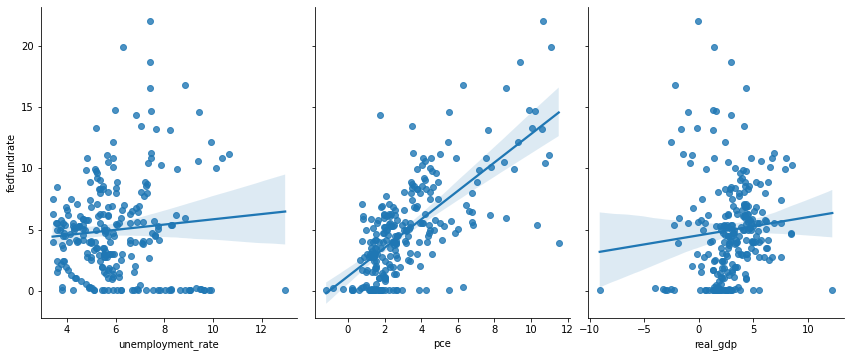

In [18]:
# Some exploratory data visualization
sns.pairplot(data=data, x_vars = ["unemployment_rate", "pce", "real_gdp"], y_vars = "fedfundrate", height=5, aspect=0.8, kind='reg')


From above graphs, there appears to be little correlation between unemployment rate/real gdp versus Fed Funds Rate based on the spread of the data points versus the best fit line generated. 

PCE appears to be most correlated to Fed Funds Rate - when PCE increases, so does Fed Funds Rate. 

We will include all 3 predictors into the linear model to see how it affects the output.

## Simple Linear Regression

In [19]:
X = data.loc[:, ["unemployment_rate", "pce", "real_gdp"]]                  
y = data.loc[:, "fedfundrate"]

# instantiate Linear Regression model
lm = LinearRegression()

LinearRegression()
intercept:  -0.3140261983822201
coefficients : [0.10679938 1.17323769 0.27613768]


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)  
print(X_train.head(3))
print(X_test.head(3))

lm.fit(X_train, y_train)                                  # to train the model
print(lm)

print("intercept: ",lm.intercept_)                         # print the coefficients
print("coefficients :", lm.coef_)
print('')

#Calculate MSE, RMSE, R2 scores for train set
y_pred_train = lm.predict(X_train)
print('Train MSE:', metrics.mean_squared_error(y_true=y_train, y_pred=y_pred_train))        #MSE, y_true are the real data points, y_pred is y_predict which is the regression line
print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=y_pred_train)))   #RMSE
print('Train R2:', metrics.r2_score(y_train, y_pred_train))
print('')

#Calculate MSE, RMSE, R2 scores for test set
y_pred_test = lm.predict(X_test)
print('Test MSE:', metrics.mean_squared_error(y_true=y_test, y_pred=y_pred_test))        #MSE, y_true are the real data points, y_pred is y_predict which is the regression line
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred_test)))   #RMSE
print('Test R2:', metrics.r2_score(y_test, y_pred_test))


     unemployment_rate      pce  real_gdp
180           5.300000  2.62657   3.90862
70            6.900000  6.76472   5.77090
190           4.666667  2.17711   2.39856
     unemployment_rate       pce  real_gdp
56            5.133333   9.05166   0.63877
127           7.100000   2.49994   1.16650
60            8.266667  10.33008  -2.29905
LinearRegression()
intercept:  -0.20563210540030852
coefficients : [0.08483166 1.29009159 0.1738911 ]

Train MSE: 7.584733494879259
Train RMSE: 2.754039486804657
Train R2: 0.5357685937261293

Test MSE: 10.296472115526932
Test RMSE: 3.2088116360308425
Test R2: 0.340819578626705


R2 train and test scores are around 0.34 to 0.53 due to the large spread of values. 

### Question: Based on the fitted model, using today's data, what would be the theoretical Fed funds rate?

In [50]:
data.tail()

,date,fedfundrate,pce,real_gdp,unemployment_rate
244,2021-01-01,0.06,1.82982,0.54698,6.200000
245,2021-04-01,0.08,3.86105,12.22668,5.900000
246,2021-07-01,0.06,4.27777,4.94656,5.100000
247,2021-10-01,0.07,5.49727,5.53348,4.233333
248,2022-01-01,0.33,6.28677,3.54469,3.800000


We extract the predictor variables (unemployment rate, pce and real_gdp) for Jan 2022 and predict the Fed Funds Rate based on the linear model.

In [60]:
# the figures below correspond to the "unemployment_rate", "pce", "real_gdp" of Jan 2022
y_pred = lm.predict(np.array([3.8, 6.28677, 3.54469]).reshape(1,-1))
print('Theoretical Fed Funds Rate:', y_pred[0])

Theoretical Fed Funds Rate: 8.843627336774643


Based on our very simple model, the theoretical fed funds rate based on January 2022's macroeconomic figures is 8.8%! However, the Fed has only as of June 2022 raised interest rates to 1.5 to 1.75% and have much catching up to do. 

## Re-Run model using PCE as predictor

We will re-run the model using only PCE as the predictor just to see how the resutls vary.

In [62]:
X = data.loc[:, "pce"]                  
y = data.loc[:, "fedfundrate"]
# display(X)

X = np.array(X).reshape(-1,1)

# instantiate and fit
lm = LinearRegression()
lm.fit(X, y)                                  # to train the model
print(lm)

# print the coefficients
print("intercept: ",lm.intercept_)
print("coefficients :", lm.coef_)

LinearRegression()
intercept:  1.194594759873978
coefficients : [1.16001447]


In [64]:
x = np.array([6.28677]).reshape(1,-1)
y_pred = lm.predict(x)
print('Theoretical Fed Funds Rate:', y_pred[0])


Theoretical Fed Funds Rate: 8.48733889925574


The theoretical Fed Funds Rate is now 8.5%, not too far from the earlier predicted value of 8.8%. This is expected because PCE shows the highest correlation to Fed Funds Rate as compared to other predictors. 

### Conclusion

In conclusion, it is clear from the above data that there is a significant disparity in current interest rates (1.5 to 1.75%) as compared to the theoretical values (~8%). Coincidentally, the theoretical interest rate also matches roughly the current inflation rate, which makes some sense given that the Fed had once raised interest rates to as high as 20% to fight inflation (in the double dights) in the 1980s. The Fed has also repeatedly telegraphed that they would be more aggressive in their monetary policy to combat inflation, which does not seem to be slowing down at the moment. The Fed now projects that the median interest rates would rise to about 3.8% in 2023. While still a far cry from our theoretical value, this may be due to the Fed adopting a wait and see approach for the economy to cool substantially after the planned series of rate hikes in 2022/2023 and easing of supply chain related factors in time to come. Nonetheless, while it can be hard to predict exactly where interest rates end up, I expect the trajectory of the interest rates to be on the uptrend and it would be prudent to take this into account when making any business / investment related decisions.